<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

##  HOW TO obtain archival ESO data given some polygon shape

The [ESO archive](http://archive.eso.org/cms.html) currently (June 2020) contains more than [1.7 million spectra](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=SPECTRUM&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22SPECTRUM%22%3atrue%7d&at=119.452774,-60.30286&sr=i), more than [650,000 images](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=IMAGE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22IMAGE%22%3atrue%7d&at=160.465004,19.501825&sr=i), and more than [240,000 cubes](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=CUBE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22CUBE%22%3atrue%7d&at=239.591811,-14.166308&sr=i) that are reduced or fully calibrated.

There are three main ways to access the vaste amount of information present in the [ESO archive](http://archive.eso.org/cms.html):

* the [Raw Data query form](http://archive.eso.org/eso/eso_archive_main.html)
* the [Science Portal](http://archive.eso.org/scienceportal/home) to browse and access the processed data
* the [Programmatic and Tools access](http://archive.eso.org/programmatic/) which permits direct database access to both raw and processed data, and to the ambient condition measurements

In addition, the <code>archive_observations</code> module part of the (unofficial) [ESOAsg](https://github.com/EmAstro/ESOAsg) package provides simple wrappers to efficiently embed the access to the [ESO archive](http://archive.eso.org/cms.html) into <code>python</code> routines.

With this example, we show how to obtain all science spectra associated to an object for which the location in the sky is known via a polygon shape. 

In case you use data from the ESO Archive for your research, please consider the [ESO acknowledgement policies](http://archive.eso.org/cms/eso-data-access-policy.html#acknowledgement).

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

**Table of Content**

0. [**Imports and instantiate the TAP service**](#imports)
1. [**Define Polygon for one or more targets**](#define)
    1. [**Check polygon with plot**](#check_poly)
2. [**Query the archive with the polygon shape**](#query)
    1. [**Check query and polygon with plot**](#check_query) 
3. [**Download the Archive Data Products**](#download_data)

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [ ]:
from ESOAsg import archive_observations # ESO Archive Observations

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
from matplotlib.patches import Polygon # Matplotlib Polygon
import numpy as np # Numpy
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header
from astroquery.skyview import SkyView # Astroquery SkyView
from astropy.wcs import WCS # Astropy World Coordinate System
import os # OS

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


---
## <a id='define'>1. Define Polygon for one or more targets </a>

For this example, we consider a standard star observed as part of the [`MUSE library of stellar spectra`](https://www.eso.org/sci/publications/announcements/sciann17288.html) project ([Ivanov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.100I/abstract)): 
* [HD 172230](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+172230&submit=SIMBAD+search).

The coordinates of these two well known stars can be simply retrieved from their name using `Sesame` (and we are storing them in the list: `star_positions`):

In [2]:
star_name = 'HD 172230'
star_position = SkyCoord.from_name(star_name)
print('{}: {}'.format(star_name, SkyCoord.from_name(star_name).to_string('hmsdms')))

HD 172230: 18h38m54.9539035s +06d16m14.8140394s


We now define some polygon shape around the source of interest, in this case with the following format 'x1,y1,x2,y2,...' Such that the string constrains the location in the sky of the polygon with RA, Dec, seprated by commas and with the first RA, Dec pair that matches the last one (to close the polygon).

```
polygons = '279.7477439, 6.291487, 279.7484656, 6.2819568, 279.7507562, 
            6.2710257, 279.7477424, 6.25102, 279.7271588, 6.248253, 279.7070334, 
            6.2510199, 279.7058524, 6.2696592, 279.7108921, 6.2842342, 279.7271587, 
            6.2912941, 279.7477439, 6.291487'
```

**A careful point** to note here is that the polygon should (as we will use it) be defined counter clockwise, which is defined as inclusion, whereas clockwise would be exclusion. As the VO convention states: "The inside of the region is defined as that part of coordinate space that is encircled by the polygon in a counter-clockwise sense".

A useful check can be found via [vo_polygons](https://archive.eso.org/programmatic/vo_polygons/?polygon=POLYGON('J2000',%20279.7477439,%206.291487,%20279.7484656,%206.2819568,%20279.7507562,%206.2710257,%20279.7477424,%206.25102,%20279.7271588,%206.248253,%20279.7070334,%206.2510199,%20279.7058524,%206.2696592,%20279.7108921,%206.2842342,%20279.7271587,%206.2912941,%20279.7477439,%206.291487)&polygon=&observer=279.72854%206.27116&zoom=1587.219804&lonlat=0&), for which we have included the example shown here. 

 


In [ ]:
polygons = """279.7477439, 6.291487, 279.7484656, 6.2819568, 279.7507562, 
            6.2710257, 279.7477424, 6.25102, 279.7271588, 6.248253, 279.7070334, 
            6.2510199, 279.7058524, 6.2696592, 279.7108921, 6.2842342, 279.7271587, 
            6.2912941, 279.7477439, 6.291487""" # Define the polygon to use for the query
polygons_arr = np.array(polygons.split(','), dtype=np.float64).reshape(-1, 2).T # Convert the string to an array of floats

### <a id='check_poly'>1.1 Check polygon with plot</a>

Now we can compare the position of the star to the chosen polygon

For this, we make use of the ``astroquery.skyview import SkyView`` package, and compare against an example DSS image.

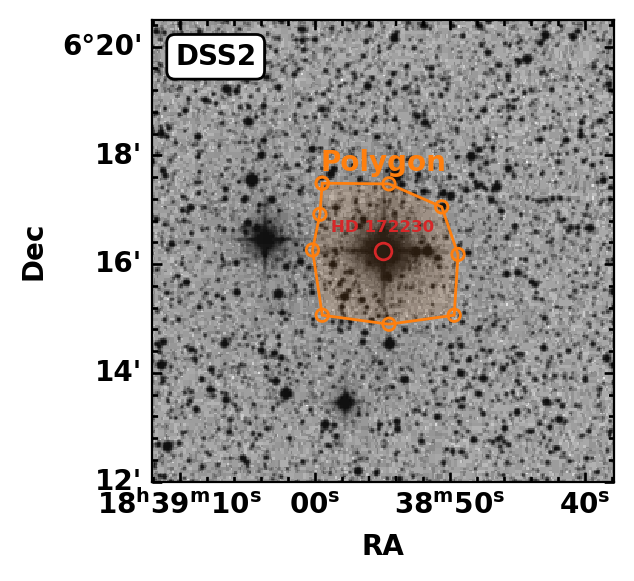

In [116]:
imglist = SkyView.get_images(position=star_position, survey='DSS')
img = imglist[0]
wcs = WCS(img[0].header)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection=wcs)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(img[0].data, cmap="gray_r", interpolation="none", origin="lower",
          norm=plt.matplotlib.colors.LogNorm())

ax.plot(star_position.ra, star_position.dec, "o", transform=ax.get_transform("fk5"), mec="C3", mfc="none") 

p1 = Polygon(polygons_arr.T, fc='C1', alpha=0.1, transform=ax.get_transform("fk5"))
p2 = Polygon(polygons_arr.T, fc='none', ec='C1', transform=ax.get_transform("fk5"))

ax.scatter(polygons_arr[0], polygons_arr[1], fc='none', ec='C1', s=20, transform=ax.get_transform("fk5"))

ax.add_patch(p1)
ax.add_patch(p2)

ax.text(star_position.ra.value, star_position.dec.value+0.005, star_name, transform=ax.get_transform("fk5"), 
        ha='center', va='bottom', fontsize=6, c='C3')
ax.text(0.05, 0.95, 'DSS2', transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1))
ax.text(0.5, 0.72, 'Polygon', transform=ax.transAxes, ha='center', va='top', color='C1')

fig.savefig('figures/HD172230_DSS2.png', bbox_inches='tight')

---
## <a id='query'>2. Query the archive with the polygon shape</a>

We can now pass this polygon to our archive search, which looks like the following:
```python
archive_observations.query_TAP_from_polygons(polygons=polygons)
```

returns the result of the query:
```SQL
SELECT
   target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
   dataproduct_type, instrument_name, abmaglim, proposal_id
FROM
   ivoa.ObsCore
WHERE
   intersects(s_region, POLYGON('', `polygon`)) = 1
```
for convenince `maxrec` is set to `20` so only the first few results are returned, but you may want to increase this value. 
```

In [108]:
result_from_query = archive_observations.query_from_polygons(polygons=polygons, maxrec=20)

[WORKING] :: Running query 1 to the ESO archive (out of 1 total)
[INFO]    :: A total of 15 entries has been retrieved (with maxrec=20)
[INFO]    :: For the following instrument:
[INFO]    ::  - MUSE
[INFO]    ::  - UVES
[INFO]    ::  - XSHOOTER


The results are stored in an astropy table. 

In [110]:
result_from_query.show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:52.997,279.729582,6.27016,2.2,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.070,279.729289,6.27105,0.665,9.9402e-07,2.47896e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.210,279.729289,6.27105,0.1,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.377,279.729289,6.27105,0.1,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.950,279.729582,6.27016,2.2,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:54.150,279.729582,6.27016,2.2,9.9402e-07,2.47896e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
HD 172230,ADP.2020-02-26T15:36:25.276,279.728983,6.270793,24.0,4.75021e-07,9.35146e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD
HD172230,ADP.2020-07-28T07:32:26.284,279.728958,6.270786,2.2,9.941209999999999e-07,2.479213e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSL
HD172230,ADP.2020-07-28T07:32:26.285,279.728958,6.270786,2.2,2.9893299999999997e-07,5.56043e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSL


### <a id='check_query'>2.1 Check query and polygon with plot</a>

Now we can compare the position of the star to the chosen polygon, and the above results. 

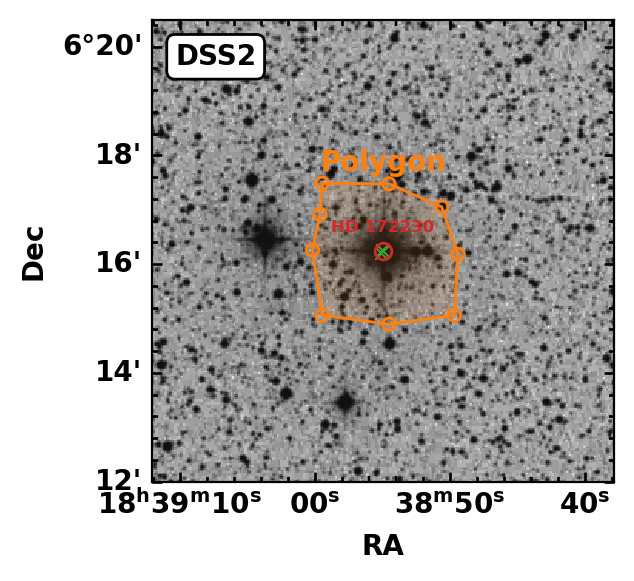

In [115]:
imglist = SkyView.get_images(position=star_position, survey='DSS')
img = imglist[0]
wcs = WCS(img[0].header)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection=wcs)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(img[0].data, cmap="gray_r", interpolation="none", origin="lower",
          norm=plt.matplotlib.colors.LogNorm())

ax.plot(star_position.ra, star_position.dec, "o", transform=ax.get_transform("fk5"), mec="C3", mfc="none") 

p1 = Polygon(polygons_arr.T, fc='C1', alpha=0.1, transform=ax.get_transform("fk5"))
p2 = Polygon(polygons_arr.T, fc='none', ec='C1', transform=ax.get_transform("fk5"))

ax.scatter(polygons_arr[0], polygons_arr[1], fc='none', ec='C1', s=20, transform=ax.get_transform("fk5"))

ax.scatter(result_from_query['s_ra'], result_from_query['s_dec'], ec='C2', s=20, transform=ax.get_transform("fk5"), marker='x', lw=0.5)

ax.add_patch(p1)
ax.add_patch(p2)

ax.text(star_position.ra.value, star_position.dec.value+0.005, star_name, transform=ax.get_transform("fk5"), 
        ha='center', va='bottom', fontsize=6, c='C3')
ax.text(0.05, 0.95, 'DSS2', transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1))
ax.text(0.5, 0.72, 'Polygon', transform=ax.transAxes, ha='center', va='top', color='C1')

fig.savefig('figures/HD172230_DSS2_results.png', bbox_inches='tight')

---
## <a id='download_data'>3. Download the Archive Data Products </a>

The next steps can follow those in ``example01_HOWTO_getDataFromRaDec.ipynb``, where we compare ``UVES``, ``MUSE``, ``XSHOOTER`` for this source.